In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from tqdm.notebook import tqdm

import librosa
import librosa.display

import torch
import torch.nn as nn
from torchsummary import summary

from common_audio import *
from audio_dataset import *

torch.manual_seed(0)
np.random.seed(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.float

print(device)


cpu


In [2]:
sr = 8000
duration = 5.0
voice_ds = AudioDataSet('datasets/LibriSpeech/LibriSpeech/dev-clean', sr=sr, duration=duration)

# Manual Method
Seperating the frequency manually from spectrogram

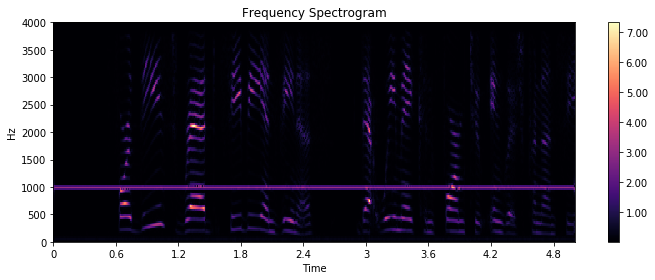

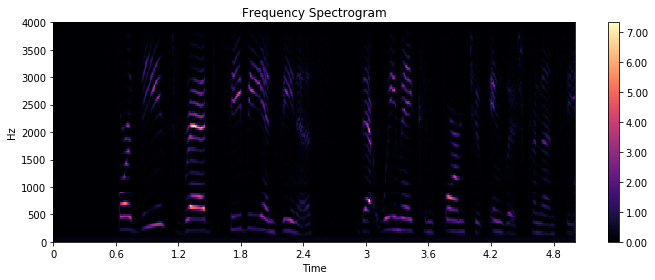

In [5]:
y_voice = voice_ds.load([0])[0]
y_tone = generate_tone(sr, duration, np.array([1000]), np.array([0.05]))[0]

y = y_voice + y_tone
play_audio(y, sr)
spectrogram = audio_to_spectrogram([y], sr)[0]

show_spectrogram(np.abs(spectrogram), sr)
plt.show()
play_audio(spectrogram_to_audio([spectrogram], sr)[0], sr)

spectrogram[30:34, :] = 0

show_spectrogram(np.abs(spectrogram), sr)
plt.show()
play_audio(spectrogram_to_audio([spectrogram], sr)[0], sr)


# Naive Method

Make a neural network to just take out the tone

In [12]:
# create test set
voice_ds.reset_next()
test_set_size = 10

X_test_voice = voice_ds.load_next(test_set_size, pbar=tqdm())
X_test_tone = generate_tone(sr, duration, np.linspace(100, 3500, test_set_size), 0.05*np.ones(test_set_size))

X_test = X_test_voice + X_test_tone
Y_test = X_test_voice

X_test = complex_to_channels(audio_to_spectrogram(X_test, sr))
Y_test = complex_to_channels(audio_to_spectrogram(Y_test, sr))
print(X_test.shape)
print(Y_test.shape)

(10, 2, 129, 626)
(10, 2, 129, 626)


In [48]:
def show_test_performance(model, X_test, Y_test, show_idx=None):
    test_eval_crit = nn.MSELoss()
    
    Y_test_pred = model.forward(torch.from_numpy(X_test).to(device, dtype)).detach()

    print('MSELoss: ', test_eval_crit(Y_test_pred, torch.from_numpy(Y_test).to(device, dtype)).item())

    Y_test_pred = Y_test_pred.cpu().numpy()
    
    if show_idx is not None:
        show_complete_spectrogram(channels_to_complex(X_test[show_idx]), sr)
        plt.show()
        play_audio(spectrogram_to_audio(channels_to_complex(X_test[show_idx:show_idx+1]), sr)[0], sr)

        show_complete_spectrogram(channels_to_complex(Y_test_pred[show_idx]), sr)
        plt.show()
        play_audio(spectrogram_to_audio(channels_to_complex(Y_test_pred[show_idx:show_idx+1]), sr)[0], sr)

In [39]:
import gc
gc.collect()

6249

In [62]:
# model = Voi
model = FTNN(2, [5, 5], num_layers_per_block=2, block_gr=5)
# model = torch.load('models/ftnn_naive.pth')

summary(model, input_size=X_test.shape[1:])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 5, 129, 626]              15
       BatchNorm2d-2          [-1, 5, 129, 626]              10
              ReLU-3          [-1, 5, 129, 626]               0
            Conv2d-4          [-1, 5, 129, 626]             230
       BatchNorm2d-5         [-1, 10, 129, 626]              20
              ReLU-6         [-1, 10, 129, 626]               0
            Conv2d-7          [-1, 5, 129, 626]             455
            Conv2d-8           [-1, 5, 64, 313]             105
       BatchNorm2d-9           [-1, 5, 64, 313]              10
             ReLU-10           [-1, 5, 64, 313]               0
           Conv2d-11           [-1, 5, 64, 313]             230
      BatchNorm2d-12          [-1, 10, 64, 313]              20
             ReLU-13          [-1, 10, 64, 313]               0
           Conv2d-14           [-1, 5, 

MSELoss:  0.24105611443519592


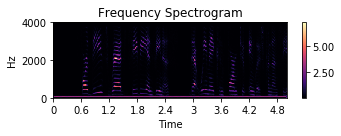

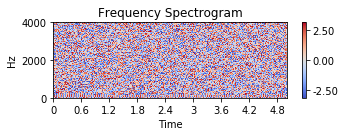

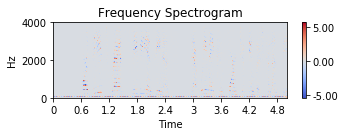

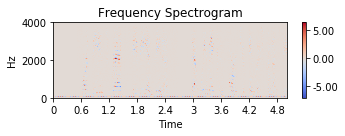

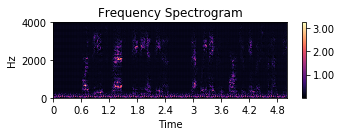

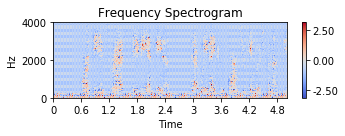

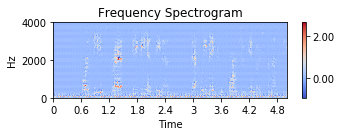

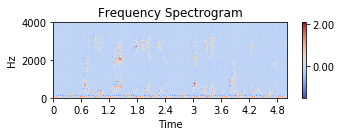

In [63]:
show_test_performance(model, X_test, Y_test, show_idx=0)

0.2972804
0.4160177
0.21461447
0.2794372
0.42474103
0.19612533
0.2168369
0.45638815
0.19110657
0.14686418
0.16181
0.1397774
0.11609389
0.16626875
0.117659606
0.15269119
0.36068887
0.16834238
0.1633803
0.14608443
0.13944894
0.23888952
0.09608488
0.09291047
0.093522035
0.11130174
0.2653992
0.11210702
0.12294976
0.15220702
0.11602655
0.11195715
0.12669961
0.093680635
0.14827257
0.122145936
0.10603609
0.08517316
0.07645482
0.065380186
0.07852304
0.079033025
0.07304572
0.06485181
0.06010025
0.07517629
0.06954672
0.056513816
0.0628243
0.06340739

CPU times: user 2min 19s, sys: 25.2 s, total: 2min 44s
Wall time: 2min 55s


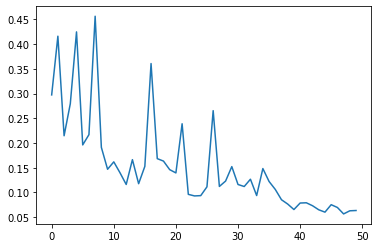

In [64]:
%%time
crit = nn.MSELoss()
losses = []
batch_size = 10
for epoch in tqdm(range(50)):
    X_batch_voice = voice_ds.load_next(batch_size, pbar=None)
    X_batch_tone = generate_tone(sr, duration, np.linspace(100, 3500, batch_size), 0.05*np.ones(batch_size))

    X_batch = X_batch_voice + X_batch_tone
    Y_batch = X_batch_voice

    X_batch = complex_to_channels(audio_to_spectrogram(X_batch, sr))
    Y_batch = complex_to_channels(audio_to_spectrogram(Y_batch, sr))
    
    X_batch = torch.from_numpy(X_batch).to(device,dtype)
    Y_batch = torch.from_numpy(Y_batch).to(device,dtype)
    
    model.opt.zero_grad()
    Y_batch_pred = model.forward(X_batch)
    loss = crit(Y_batch_pred, Y_batch)
    
    loss.backward()
    
    model.opt.step()
    
    loss = loss.detach().cpu().numpy()
    losses.append(loss)
    print(loss)
    
plt.plot(np.arange(len(losses)), losses)

MSELoss:  0.08220929652452469


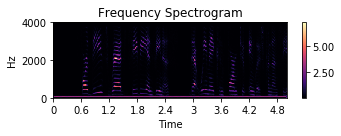

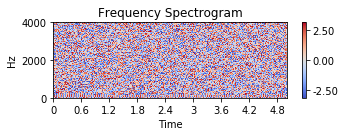

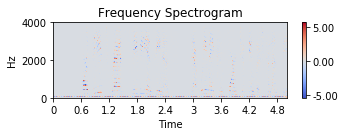

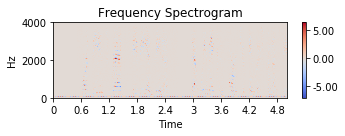

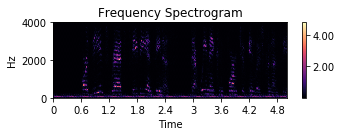

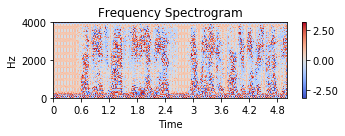

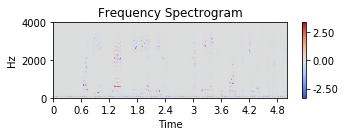

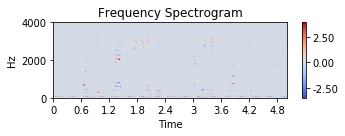

In [53]:
show_test_performance(model, X_test, Y_test, show_idx=0)

In [59]:
torch.save(model, 'models/ftnn_naive.pth')

# Our Method

Generator-Discriminator setup (without GAN)

In [ ]:
class DModel():
    pass
class GModel():
    pass

In [ ]:
def loss_func(generator_out):

In [5]:
# create test set
voice_ds.reset_next()
X_test_voice = voice_ds.load_next(100, pbar=tqdm())
X_test_tone = generate_tones(sr, duration, np.linspace(500, 2000, 100))

X_test = np.concatenate((X_test_voice, X_test_tone), axis=0)
Y_test = np.concatenate((np.ones(X_test_voice.shape[0]), np.zeros(X_test_tone.shape[0])), axis=0)

X_test = audios_to_spectrograms(X_test, sr, normalize=True)


In [6]:
tin = torch.from_numpy(X_test).to(device,dtype)[:,None, :, :]
tout = vrn.forward(tin).detach().cpu().numpy()[:, 0]

print('Accuracy: ', ((tout>0.5) == (Y_test>0.5)).sum()/len(Y_test))

Accuracy:  0.5


0.69328344
0.625149
0.50964385
0.3580653
0.18374917
0.10838596
0.045182668
0.015382772
0.0047557587
0.002027946
0.00070683996
0.000681378
5.9180642e-05
2.2062975e-05
0.00017370297
3.6984843e-06
6.565458e-05
7.722303e-06
2.1253485e-05
4.0233226e-07
2.3841886e-07
6.311936e-05
2.9802323e-09
3.278266e-07
0.0
2.3841864e-08
0.0
0.0
0.0
0.0
0.0
2.3841864e-08
9.5367525e-08
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0

CPU times: user 1min 11s, sys: 4.57 s, total: 1min 15s
Wall time: 51.3 s


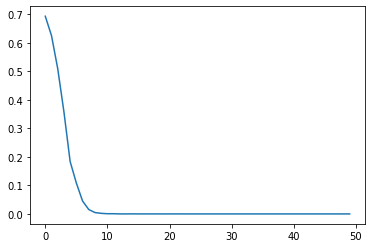

In [7]:
%%time
crit = nn.BCELoss()
losses = []
batch_num = 10
for epoch in tqdm(range(50)):
    X_batch_voice = voice_ds.load_next(batch_num, pbar=None)
    X_batch_tone = generate_tones(sr, duration, np.linspace(500, 2000, batch_num))

    X_batch = np.concatenate((X_batch_voice, X_batch_tone), axis=0)
    Y_batch = np.concatenate((np.ones(X_batch_voice.shape[0]), np.zeros(X_batch_tone.shape[0])), axis=0)

    X_batch = audios_to_spectrograms(X_batch, sr, normalize=True)
    X_batch = torch.from_numpy(X_batch).to(device,dtype)[:,None, :, :]
    Y_batch = torch.from_numpy(Y_batch).to(device,dtype)

    
    vrn.opt.zero_grad()
    Y = vrn.forward(X_batch)[:, 0]
    loss = crit(Y, Y_batch)
    
    loss.backward()
    
    vrn.opt.step()
    
    loss = loss.detach().cpu().numpy()
    losses.append(loss)
    print(loss)
    
plt.plot(np.arange(len(losses)), losses)

In [8]:
tin = torch.from_numpy(X_test).to(device,dtype)[:,None, :, :]
tout = vrn.forward(tin).detach().cpu().numpy()[:, 0]

print('Accuracy: ', ((tout>0.5) == (Y_test>0.5)).sum()/len(Y_test))

Accuracy:  1.0


In [ ]:
# real neural network here

In [ ]:
import gc
gc.collect()

In [3]:
def get_block_layer(c_in, c_out, kernel_size=3, padding=1):
    return nn.Sequential(nn.BatchNorm2d(c_in), 
                         nn.ReLU(), 
                         nn.Conv2d(c_in, c_out, kernel_size, padding=padding))
    

class NeuralTransform(nn.Module):
    def __init__(self, c_in, c_out, num_layers, gr):
        super().__init__()
        self.c_in = c_in
        self.c_out = c_out
        
        self.layers = nn.ModuleList()
        
        c_prev = c_in
        for layer_idx in range(num_layers-1):
            self.layers.append(get_block_layer(c_prev, gr))
            c_prev += gr
            
        self.final_layer = get_block_layer(c_prev, c_out)
        
        
    def forward(self, x):
        for layer in self.layers:
            x = torch.cat((x, layer(x)), axis=1)
        x = self.final_layer(x)
        return x
    
def get_down_sample(c, kernel_size=(2,2), stride=(2,2)):
    return nn.Conv2d(c, c, kernel_size=kernel_size, stride=stride)
def get_up_sample(c, kernel_size=(2,2), stride=(2,2)):
    return nn.ConvTranspose2d(c, c, kernel_size=kernel_size, stride=stride)

class FTNN(nn.Module):
    def __init__(self, c_raw, cs, num_layers_per_block=4, block_gr=24):
        super().__init__()
        rcs = list(reversed(cs))
        
        self.conv_first = nn.Conv2d(c_raw, cs[0], kernel_size=1)
        self.conv_last = nn.Conv2d(rcs[-1], c_raw, kernel_size=1)
        
        self.left = nn.ModuleList([NeuralTransform(c_in, c_out, num_layers_per_block, block_gr) for c_in, c_out in zip(cs, cs[1:])])
        self.right = nn.ModuleList([NeuralTransform(2*c_in, c_out, num_layers_per_block, block_gr) for c_in, c_out in zip(rcs, rcs[1:])])
        
        self.midnt = NeuralTransform(cs[-1], cs[-1], num_layers_per_block, block_gr)
        
        self.downs = nn.ModuleList([get_down_sample(c) for c in cs[1:]])
        self.ups = nn.ModuleList([get_up_sample(c) for c in rcs[:-1]])
        
        self.opt = torch.optim.Adam(self.parameters(), lr=0.001)
    
    def forward(self, x):
        x = self.conv_first(x)
        
        residuals = []
        shapes = []
        for nt, down in zip(self.left, self.downs):
            x = nt.forward(x)
            residuals.insert(0, x)
            shapes.insert(0, x.shape)
            x = down(x)
        
        x = self.midnt(x)
        
        for nt, up, residual, shape in zip(self.right, self.ups, residuals, shapes):
            x = up(x, output_size=shape)
            x = torch.cat((x, residual), dim=1)
            x = nt.forward(x)
        
        x = self.conv_last(x)
        return x
    
# rn = TFNN(2, [12, 12, 12, 12, 12]).to(device, dtype)
# summary(rn, input_size=(2, 63, 63), batch_size=-1)



In [21]:
class NaiveVoiceIsolaterNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.maxpool = nn.MaxPool2d((2,2), return_indices=True)
        self.maxunpool = nn.MaxUnpool2d((2,2))
        self.conv1 = nn.Conv2d(2, 4, 3, padding=1)
        self.conv2 = nn.Conv2d(4, 6, 3, padding=1)
        self.conv3 = nn.Conv2d(6, 8, 3, padding=1)
        
        self.linear1 = nn.Linear(9984, 100)
        self.linear2 = nn.Linear(100, 9984)
        
        self.convt1 = nn.ConvTranspose2d(8, 6, 3, padding=1)
        self.convt2 = nn.ConvTranspose2d(6, 4, 3, padding=1)
        self.convt3 = nn.ConvTranspose2d(4, 2, 3, padding=1)
        
        self.opt = torch.optim.Adam(self.parameters(), lr=0.001)
    
    def forward(self, x):
        size0 = x.size()
        
        x = self.conv1(x)
        x, ind1 = self.maxpool(x)
        size1 = x.size()
        x = torch.relu(x)

        
        x = self.conv2(x)
        x, ind2 = self.maxpool(x)
        size2 = x.size()
        x = torch.relu(x)


        x = self.conv3(x)
        x, ind3 = self.maxpool(x)
        size3 = x.size()
        x = torch.relu(x)
        
        y = x.view(x.shape[0], -1)
        
        y = self.linear1(y)
        y = torch.relu(y)
        
        y = self.linear2(y)
        y = torch.relu(y)
        
        y = y.view(x.shape)
        
        x = x + y

        x = self.maxunpool(x, ind3, output_size=size2)
        x = self.convt1(x)
        x = torch.relu(x)
        
        x = self.maxunpool(x, ind2, output_size=size1)
        x = self.convt2(x)
        x = torch.relu(x)
        
        x = self.maxunpool(x, ind1, output_size=size0)
        x = self.convt3(x)
#         x = torch.relu(x)
        
        return x

In [22]:
class VoiceRecogNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.maxpool = nn.MaxPool2d((2,2))
        self.conv1 = nn.Conv2d(1, 4, 3, padding=1)
        self.conv2 = nn.Conv2d(4, 16, 3, padding=1)
        self.conv3 = nn.Conv2d(16, 64, 3, padding=1)
        self.linear = nn.Linear(12288, 100)
        self.linear2 = nn.Linear(100, 10)
        self.linear3 = nn.Linear(10, 1)
        
        self.opt = torch.optim.Adam(self.parameters(), lr=0.001)
    
    def forward(self, x):

        x = self.conv1(x)
        x = self.maxpool(x)
        x = torch.tanh(x)

        x = self.conv2(x)
        x = self.maxpool(x)
        x = torch.tanh(x)

        x = self.conv3(x)
        x = self.maxpool(x)
        x = torch.tanh(x)
        
        x = x.view(x.shape[0], -1)
        
        x = self.linear(x)
        x = torch.relu(x)
        
        x = self.linear2(x)
        x = torch.relu(x)
        
        x = self.linear3(x)
        x = torch.sigmoid(x)
        
        return x

In [8]:
%%time
model = FTNN(2, [12,12,12,12,12])

summary(model, input_size=(2, 1023, 1023), batch_size=10)

KeyboardInterrupt: 